In [ ]:
#default_exp core.data

# Sneaker Finder development notebook

### version 0.1 Jan 2020
### version 0.2 Feb 2020
### version 0.3 June 2020
### version 1.0 Dec 2020 (refactor using pytorch/nbdev/fastai framework)

# OVERVIEW

This is a project initiated while an Insight Data Science fellow.  It grew out of thinking about how to make data-driven tools that could impact the fashion industry which I had been working working in.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some sneaker designs based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

This is a cool reference for a fastai VAE
https://medium.com/@dhuynh95/an-introduction-to-unsupervised-learning-with-fastai-a6dbd78eca2b


In [ ]:
#hide
from fastbook import *
from fastai.vision.all import *

First we need to get a database of sneaker images.   The sneaker images are only 136 pixels wide, and organized by 'Category', 'SubCategory', and 'Brand'.   Additional semantic information is also available from Mechanical Turk labeling, and is available packed into matlab files.  

In [ ]:
DB_path = Path.home()/'Projects/DATABASE'
DB_path

Path('/home/ergonyc/Projects/DATABASE')

# Part 0: DATA

## Part 1: import the UT-Zappos50k database

untar_data

In [ ]:
# don't use the "square" versions because they are excessively padded.  we'll simply pad with "white"
#url_images = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip"
url_images = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip"
# the images are wider than tall with the product already taking up aproximately the whole vertical dimension
url_meta = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-data.zip"

DATA_path = Path.home()/'Projects/DATABASE'

path_meta = untar_data(url_meta, dest=DATA_path)
path_images = untar_data(url_images,dest=DATA_path)

## data set cleaning

The dataset is very diverse and not constructed in order to think about how popular footwear is aesthetically related.  I'm simplifying the database to include 4 categories which seem to split aesthetics for general footwear:

1) BOOTS - weatherized and/or protected footwear for work or outdoor activity
2) SANDALS - charachterized by a sole and straps
3) SHOES - generic non "boot" footwear.  includes heels and formalwear
4) SNEAKERS - atheletic / comfort inspired 

In [ ]:
import scipy.io as sio

def path_from_mat(fname):
    """ reads zappos imagepath from matlab file"""
    data = sio.loadmat(fname)['imagepath']
    return [i[0][0] for i in data]

image_path = path_from_mat(path_meta/'image-path.mat')
df = pd.read_csv(path_meta/'meta-data.csv')

df["path"]=image_path

In [ ]:
# ad sub-categories (one-hot)
categories=pd.read_csv(path_meta/'meta-data-bin.csv')
df = pd.merge(df, categories,  how='left', on='CID')# left_on=['CID'], right_on = ['CID'])


# fix the path by remove trailing periods in folder names
df.loc[df.path.str.contains("./",regex=False),"path"] = [i.replace("./","/") for i in df.loc[df.path.str.contains("./",regex=False),"path"]]
df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"] = [i.replace("Levi\'s ","Levis ") for i in df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"]]

In [ ]:
# create brands and category stubs...
df['path_and_file'] = df.path.apply(lambda path: (os.path.normpath(path)).split(os.sep) ) 
df_to_add = pd.DataFrame(df['path_and_file'].tolist(), columns=['Category1','Category2','Brand','Filename'])

df = df.merge(df_to_add, left_index=True, right_index=True)
#df = pd.merge(df, df_to_add, left_index=True, right_index=True)

In [ ]:
# df.loc[df.path.str.contains("\'",regex=False),"path"]

assert (df['Category'] == df['Category1']).all()
assert (df['SubCategory'] == df['Category2']).all()


In [ ]:
df.Gender.value_counts()

Women                   26949
Men                     12107
Girls                    5233
Boys                     3187
Boys;Girls               1304
Men;Women                1226
Women;Girls                 9
Men;Boys;Women;Girls        4
Name: Gender, dtype: int64

## simplify:

Categories:
    1. SHOES, 
    2. BOOTS, 
    3. "SNEAKERS", and 
    4. "SLIPPERS"

[[ TODO:  change the bullets to a short paragraph describing the simplificaiton ]]

Only include "adult" shoes
    - Adult = mens + womens (kids = not adults),+ etc (unisex)

To construct these from the Zappos I needed to pull sneakers from shoes and exclude some sub-categories.  e.g. tall boots which would drive the representation of boots.

    BOOTS:
      BOOTS
        - ankle,  mid-calf
        - exclude: knee high , over the knee , prewalker

    SANDALS:
      SANDALS
        - athletic, flat
        - exclude: heels 
        
    SHOES:
      SHOES
        - Boat shoes, clogs and mules,  flats,  loafers, oxfords, prewalker
        - exclude: heels , crib shoes , firstwalker (exclude)

    SNEAKERS
       SHOES
       - sneakers and athletic shoes

     SLIPPERS (exclude)

In [ ]:
# add our "sneaker category"
df.loc[:,'Sneakers'] = (df['Category2'] == 'Sneakers and Athletic Shoes')

# refine boot
df.loc[:,'Boots'] = (  (df.Category1 == 'Boots') 
                     & (df.Category2 != 'Knee High')
                     & (df.Category2 != 'Over the Knee')
                     & (df.Category2 != 'Prewalker Boots') )

# refine shoes
df.loc[:,'Shoes'] = (  (df.Category1 == 'Shoes') 
                     & (df.Category2 != 'Sneakers and Athletic Shoes')
                     & (df.Category2 != 'Crib Shoes')
                     & (df.Category2 != 'Firstwalker')
                     & (df.Category2 != 'Prewalker') )

# refine shoes
df.loc[:,'Slippers'] = (  (df.Category1 == 'Shoes') 
                     & (df.Category2 != 'Sneakers and Athletic Shoes')
                     & (df.Category2 != 'Crib Shoes')
                     & (df.Category2 != 'Firstwalker')
                     & (df.Category2 != 'Prewalker') )

# define Slippers 
df.loc[:,'Slippers'] = (df.Category1 == 'Slippers')
                

In [ ]:
############
#remove ([ 'Boys',  'Boys;Girls', 'Girls','Women;Girls', nan

mens =  df['Gender'] == 'Men'       
womens =  df['Gender'] == 'Women' 
etc =  df['Gender'].str.contains('Men;', na=False)

df.loc[:,'Adult'] = mens | womens | etc

df.loc[:,'Mens'] = mens 
df.loc[:,'Womens'] = womens

df.loc[:,'OGcategory'] = df.Category
df.loc[:,'Category'] = pd.NA

df.loc[(df.Shoes==1),'Category'] = 'Shoes'
df.loc[(df.Boots==1),'Category'] = 'Boots'
df.loc[(df.Sneakers==1),'Category'] = 'Sneakers'
df.loc[(df.Slippers==1),'Category'] = 'Slippers'
df.columns

Index(['CID', 'Category', 'SubCategory', 'HeelHeight', 'Insole', 'Closure',
       'Gender', 'Material', 'ToeStyle', 'path',
       ...
       'Brand', 'Filename', 'Sneakers', 'Boots', 'Shoes', 'Slippers', 'Adult',
       'Mens', 'Womens', 'OGcategory'],
      dtype='object', length=174)

In [ ]:

# make some expository columns 
keep_columns = ['CID','Category',
                 'path','path_and_file',
                 'Category1', 'Category2','OGcategory'
                 'Brand','Filename',
                 'Sneakers','Boots',
                 'Shoes', 'Slippers','Adult',
                 'Gender']

df = df.filter(items=keep_columns)
df.columns

Index(['CID', 'Category', 'path', 'path_and_file', 'Category1', 'Category2',
       'Filename', 'Sneakers', 'Boots', 'Shoes', 'Slippers', 'Adult',
       'Gender'],
      dtype='object')

In [ ]:
#Only keep Adult (men+women) and Sneakers, Boots, Shoes
#keep Adult, Sneakers, Boots, Shoes, Slippers
keep_rows = (df.Sneakers | df.Boots | df.Shoes| df.Slippers) & (df.Adult)
df = df[keep_rows.values]
df.columns

Index(['CID', 'Category', 'path', 'path_and_file', 'Category1', 'Category2',
       'Filename', 'Sneakers', 'Boots', 'Shoes', 'Slippers', 'Adult',
       'Gender'],
      dtype='object')

------------

# Save the simplified dataframe for further analysis


Also use sklearn `train_test_split` to create category stratified train/test/validate groups.  We'll keep 15 percent of our data to truly test.

In [ ]:
from sklearn.model_selection import train_test_split
X = df.index
y = df.Category

train_ratio = 0.70
validation_ratio = 0.15

# keep
test_ratio = 0.15

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,stratify=y, random_state=666)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test, random_state=666) 


In [ ]:
# pack into the dataframe
df.loc[:,'train'] = False
df.loc[:,'test'] = False
df.loc[:,'validate'] = False
df.loc[:,'t_t_v'] = 'train'
df.loc[x_train,'train'] = True
df.loc[x_test,'test'] = True
df.loc[x_val,'validate'] = True
df.loc[x_test,'t_t_v'] = 'test'
df.loc[x_val,'t_t_v'] = 'valid'

In [ ]:
# save it
filename = "zappos-50k-simplified"
#df.to_csv(f"data/{filename}.csv")
df.to_pickle(f"data/{filename}.pkl")
df.to_json(f"data/{filename}.json")

In [ ]:
df2 = df.sort_values('path', ascending=True)
df2 = df2.reset_index(drop=True)
#df4_[["CID","path","classes"]].head(5)

filename = "zappos-50k-simplified_sort"
#df.to_csv(f"data/{filename}.csv")
df2.to_pickle(f"data/{filename}.pkl")
df2.to_json(f"data/{filename}.json")

df2.head(3)

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,False,True,Men,True,False,False,train
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,False,True,Men,True,False,False,train
2,8000978-364150,Boots,Boots/Ankle/A. Testoni/8000978.364150.jpg,"[Boots, Ankle, A. Testoni, 8000978.364150.jpg]",Boots,Ankle,8000978.364150.jpg,False,True,False,False,True,Men,False,True,False,test


In [ ]:
df2.shape

(33229, 17)

------------

# Extract features wiht MobileNetV2 

In [ ]:
filename = "zappos-50k-simplified_sort"
#df = pd.read_csv(f"data/{filename}.csv")
df = pd.read_pickle(f"data/{filename}.pkl")
#df = pd.read_json(f"data/{filename}.json")
df.head(5)
# note that reading as .csv creates a new "index" + "Unnamed: 0" column
# json and pickles work... json has rounding error for the vectors below (since it save value as text) 

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,False,True,Men,True,False,False,train
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,False,True,Men,True,False,False,train
2,8000978-364150,Boots,Boots/Ankle/A. Testoni/8000978.364150.jpg,"[Boots, Ankle, A. Testoni, 8000978.364150.jpg]",Boots,Ankle,8000978.364150.jpg,False,True,False,False,True,Men,False,True,False,test
3,8113228-1897,Boots,Boots/Ankle/AIGLE/8113228.1897.jpg,"[Boots, Ankle, AIGLE, 8113228.1897.jpg]",Boots,Ankle,8113228.1897.jpg,False,True,False,False,True,Women,True,False,False,train
4,8113228-1912,Boots,Boots/Ankle/AIGLE/8113228.1912.jpg,"[Boots, Ankle, AIGLE, 8113228.1912.jpg]",Boots,Ankle,8113228.1912.jpg,False,True,False,False,True,Women,True,False,False,train


# torchvision 

We will use Google's mobileNetV2 trained on ImageNet loaded from torchvision to embed our sneakers into a feature space.  

In [ ]:
import torchvision


mnetv2  = torchvision.models.mobilenet_v2(pretrained=True)

## use an "identity" layer to replace 1000 category classifier
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


mnetv2.classifier = Identity()
# check the
mnetv2.features

Sequential(
  (0): ConvBNReLU(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      

Because we simply want to collect the _features_ output from the model rather than do classification (or some other decision) I replaced the clasiffier _head_ with a simple identity mapper.   The simple Identity nn.Module class makes this simple.

Finally, since we are calculating the features, or _embedding_ over 30k images with the net lets load the computations onto our GPU.

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mnetv2 = mnetv2.to(device)


for param in mnetv2.parameters():
    param.requires_grad = False

device

device(type='cuda', index=0)

------------

## load the data

Next, we are ready to load the images, resize them to 224x224, make them square (by extending the white backgrounds), and finally normalizing them accourding to the ImageNet pixel value statistics for each (R,G,B) channel.

Note that the fastai dataloaders dfaults to load onto the GPU.  But to be explicit we'll add `device=device` as an argument. 

In [ ]:
# set the default to what mobileNetV2 expects... 
# note this is an "upscaling" of the UTZappos Db, but should be fine/useful for other higher resolution data

IMG_SIZE = 224
#fastai puts these stats here:
imagenet_stats

I want to make all of the images square by extending the white background image.  The easiest way will be to use the fastai framework for my "prepprocessing" rather than torch transforms.





In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# set up the helper functions to pass data into the
def get_x(r): return path_images/r['path']
#def get_y(r): return r['Category']  # we aren't actually using the category here (see 02_model.ipynb)
def get_fname(r): return r['path']

def get_query(fn): return fn


# put everythign in train, and don't do any augmentation since we are just going 
# resize to 224
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_fname,
                   item_tfms=Resize(IMG_SIZE, method='pad', pad_mode='border'),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))  # border pads white...


In [ ]:
dblock.summary(df)


Setting-up type transforms pipelines
0        7965307-5291     Boots   
1      7999255-363731     Boots   
2      8000978-364150     Boots   
3        8113228-1897     Boots   
4        8113228-1912     Boots   
...               ...       ...   
33224      105772-570  Slippers   
33225       105772-72  Slippers   
33226     117456-7907  Slippers   
33227     7590239-255  Slippers   
33228      7590239-72  Slippers   

                                                      path  \
0                  Boots/Ankle/A. Testoni/7965307.5291.jpg   
1                Boots/Ankle/A. Testoni/7999255.363731.jpg   
2                Boots/Ankle/A. Testoni/8000978.364150.jpg   
3                       Boots/Ankle/AIGLE/8113228.1897.jpg   
4                       Boots/Ankle/AIGLE/8113228.1912.jpg   
...                                                    ...   
33224   Slippers/Slipper Heels/Daniel Green/105772.570.jpg   
33225    Slippers/Slipper Heels/Daniel Green/105772.72.jpg   
33226  Slippers/Sli


No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
    starting from
      (TensorImage of size 4x3x224x224, TensorCategory([0, 1, 2, 3], device='cuda:0'))
    applying IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} gives
      (TensorImage of size 4x3x224x224, TensorCategory([0, 1, 2, 3], device='cuda:0'))
    applying Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)} gives
      (TensorImage of size 4x3x224x224, TensorCategory([0, 1, 2, 3], device='cuda:0'))


In [ ]:
dls = dblock.dataloaders(df,bs=128,drop_last=False,device=device)
#Now that I've read


dls.train.shuffle=False

In [ ]:
# simply iterate through out dataset 128 at at time.
vects = []
clss = []
paths = []
batchn = 0

for imgs,classes in dls.train:
    outs = mnetv2(imgs).data.cpu().numpy()
    vects.extend(list(outs))
    cs = classes.data.cpu().numpy()
    clss.extend(list(cs))
    ps = [dls[0].vocab[c] for c in cs]
    # keep the paths for sanity check
    paths.extend(ps)
    batchn += 1

In [ ]:
#x,y = zip(*dls.train_ds)

In [ ]:
#store all relevant info in a pandas datafram 
df_feat = pd.DataFrame({"path": paths, "classes":clss, "features":vects})
df_feat.head()

,path,classes,features
0,Boots/Ankle/A. Testoni/7965307.5291.jpg,0,"[0.76155853, 0.10984466, 1.1366137, 0.56001604, 0.21768641, 2.1468375, 1.2038145, 1.989671, 1.0295758, 0.43162146, 1.4999156, 0.021458182, 0.21626869, 0.011704099, 0.8262586, 0.40341088, 1.615078, 0.21926515, 0.4485145, 0.75489277, 0.35114518, 0.835781, 0.2452454, 0.47321704, 0.6511229, 0.379562, 1.2451965, 0.10352212, 0.4640157, 0.45415676, 0.33695024, 0.7608583, 1.1122092, 0.7242132, 0.09427358, 0.20925167, 0.7454918, 0.050915845, 0.89355904, 0.28572124, 0.5865204, 0.119453415, 0.5884168, 0.06982615, 0.27978, 1.0375984, 0.490779, 0.72360116, 1.2646871, 0.05877701, 0.064850055, 0.43443406..."
1,Boots/Ankle/A. Testoni/7999255.363731.jpg,1,"[0.44345498, 0.9290489, 0.1654758, 0.5360508, 1.2809625, 0.5138698, 0.028871076, 1.2831583, 1.5741379, 0.5079286, 1.189505, 0.68395996, 0.0, 0.8246908, 0.25864008, 0.22369127, 0.26433867, 0.86243933, 0.1723706, 0.6714099, 0.69898146, 1.4139258, 0.26837564, 0.51528573, 0.52887136, 1.7544099, 0.23532498, 0.2511827, 0.78700596, 1.5964448, 1.9869499, 0.18321559, 1.2328465, 0.18780781, 0.4149886, 0.010405556, 0.09307541, 0.9513337, 0.13541031, 0.6025493, 0.9917988, 0.4661379, 0.43161803, 1.5480949, 0.14802077, 0.16905081, 1.2777077, 0.004777289, 0.3449651, 0.43395144, 0.5679102, 1.7141621, 0.46..."
2,Boots/Ankle/A. Testoni/8000978.364150.jpg,2,"[0.14355762, 0.0883103, 0.37737238, 0.42302212, 0.78702044, 0.9093508, 0.72346216, 0.79496855, 0.60886395, 0.19213006, 1.0582442, 0.4138845, 0.29207292, 0.2328852, 1.0554103, 0.17823608, 0.3470767, 0.8730927, 0.059068017, 0.13049477, 0.46216625, 0.23315825, 0.6577207, 0.029731186, 0.43697962, 0.23015495, 0.3676944, 0.049558643, 0.31101722, 0.3297706, 0.066825345, 0.77184504, 0.6704081, 0.96005, 0.5631137, 0.20023727, 0.32141978, 0.15040031, 1.9335159, 0.1236456, 0.399957, 0.67231244, 1.4152974, 0.5653193, 0.15902497, 0.17619514, 0.31059298, 0.5539539, 0.6218819, 0.19211733, 1.6348823, 0.42..."
3,Boots/Ankle/AIGLE/8113228.1897.jpg,3,"[0.15395425, 0.13410096, 0.19743384, 0.040691588, 0.44169483, 0.006921175, 0.6286904, 0.2721087, 0.9748477, 0.013304214, 0.039741293, 0.058189195, 0.017123045, 0.1642327, 0.19519585, 0.56847, 1.4570063, 0.359661, 0.26098266, 0.4688079, 0.3572191, 0.7797074, 0.4933622, 0.16668624, 0.6989846, 0.3180049, 0.9043413, 0.8642135, 1.0292522, 0.118747555, 0.2913338, 0.83504444, 0.078910954, 0.3885277, 0.6931794, 0.61045635, 0.123014584, 1.5005904, 0.46279347, 0.84338105, 0.3978329, 0.8770881, 0.74495506, 0.4033767, 0.6618174, 0.060405146, 1.4767346, 0.72831815, 0.32693395, 0.28860605, 0.8080658, 0...."
4,Boots/Ankle/AIGLE/8113228.1912.jpg,4,"[0.4185173, 0.46893927, 0.05106433, 0.17156012, 0.7562777, 0.16275088, 0.12650095, 0.051147826, 0.5960764, 0.009451437, 0.105612226, 0.15036139, 0.034908235, 0.7476143, 0.8342173, 1.669977, 0.2943625, 0.4246886, 0.16649017, 0.67662174, 0.3653418, 0.42363295, 0.29102832, 0.3442124, 0.49557993, 0.84450275, 0.9204933, 0.59205747, 0.55316895, 0.106427126, 0.69628173, 0.9303061, 0.033223692, 0.20872036, 0.43992233, 0.38235694, 0.5043976, 1.3059714, 0.36954993, 0.89023554, 0.06700714, 0.2565222, 0.8470083, 0.7500499, 0.3632181, 0.32809034, 1.5019456, 0.24198452, 0.62264967, 0.22793092, 0.7849569..."


--------
Merge the _features_ into our dataframe.   

In [ ]:
#df2 = df.merge(df_feat)  
# explicitly:
df2 = pd.merge(df, df_feat,  how='left', on='path')
df2.head(3)

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v,classes,features
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,False,True,Men,True,False,False,train,0,"[0.76155853, 0.10984466, 1.1366137, 0.56001604, 0.21768641, 2.1468375, 1.2038145, 1.989671, 1.0295758, 0.43162146, 1.4999156, 0.021458182, 0.21626869, 0.011704099, 0.8262586, 0.40341088, 1.615078, 0.21926515, 0.4485145, 0.75489277, 0.35114518, 0.835781, 0.2452454, 0.47321704, 0.6511229, 0.379562, 1.2451965, 0.10352212, 0.4640157, 0.45415676, 0.33695024, 0.7608583, 1.1122092, 0.7242132, 0.09427358, 0.20925167, 0.7454918, 0.050915845, 0.89355904, 0.28572124, 0.5865204, 0.119453415, 0.5884168, 0.06982615, 0.27978, 1.0375984, 0.490779, 0.72360116, 1.2646871, 0.05877701, 0.064850055, 0.43443406..."
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,False,True,Men,True,False,False,train,1,"[0.44345498, 0.9290489, 0.1654758, 0.5360508, 1.2809625, 0.5138698, 0.028871076, 1.2831583, 1.5741379, 0.5079286, 1.189505, 0.68395996, 0.0, 0.8246908, 0.25864008, 0.22369127, 0.26433867, 0.86243933, 0.1723706, 0.6714099, 0.69898146, 1.4139258, 0.26837564, 0.51528573, 0.52887136, 1.7544099, 0.23532498, 0.2511827, 0.78700596, 1.5964448, 1.9869499, 0.18321559, 1.2328465, 0.18780781, 0.4149886, 0.010405556, 0.09307541, 0.9513337, 0.13541031, 0.6025493, 0.9917988, 0.4661379, 0.43161803, 1.5480949, 0.14802077, 0.16905081, 1.2777077, 0.004777289, 0.3449651, 0.43395144, 0.5679102, 1.7141621, 0.46..."
2,8000978-364150,Boots,Boots/Ankle/A. Testoni/8000978.364150.jpg,"[Boots, Ankle, A. Testoni, 8000978.364150.jpg]",Boots,Ankle,8000978.364150.jpg,False,True,False,False,True,Men,False,True,False,test,2,"[0.14355762, 0.0883103, 0.37737238, 0.42302212, 0.78702044, 0.9093508, 0.72346216, 0.79496855, 0.60886395, 0.19213006, 1.0582442, 0.4138845, 0.29207292, 0.2328852, 1.0554103, 0.17823608, 0.3470767, 0.8730927, 0.059068017, 0.13049477, 0.46216625, 0.23315825, 0.6577207, 0.029731186, 0.43697962, 0.23015495, 0.3676944, 0.049558643, 0.31101722, 0.3297706, 0.066825345, 0.77184504, 0.6704081, 0.96005, 0.5631137, 0.20023727, 0.32141978, 0.15040031, 1.9335159, 0.1236456, 0.399957, 0.67231244, 1.4152974, 0.5653193, 0.15902497, 0.17619514, 0.31059298, 0.5539539, 0.6218819, 0.19211733, 1.6348823, 0.42..."


In [ ]:
df2 = df2.sort_values('path', ascending=True)
df2 = df2.reset_index(drop=True)
#df4_[["CID","path","classes"]].head(5)

df2.head(3)

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v,classes,features
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,False,True,Men,True,False,False,train,0,"[0.76155853, 0.10984466, 1.1366137, 0.56001604, 0.21768641, 2.1468375, 1.2038145, 1.989671, 1.0295758, 0.43162146, 1.4999156, 0.021458182, 0.21626869, 0.011704099, 0.8262586, 0.40341088, 1.615078, 0.21926515, 0.4485145, 0.75489277, 0.35114518, 0.835781, 0.2452454, 0.47321704, 0.6511229, 0.379562, 1.2451965, 0.10352212, 0.4640157, 0.45415676, 0.33695024, 0.7608583, 1.1122092, 0.7242132, 0.09427358, 0.20925167, 0.7454918, 0.050915845, 0.89355904, 0.28572124, 0.5865204, 0.119453415, 0.5884168, 0.06982615, 0.27978, 1.0375984, 0.490779, 0.72360116, 1.2646871, 0.05877701, 0.064850055, 0.43443406..."
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,False,True,Men,True,False,False,train,1,"[0.44345498, 0.9290489, 0.1654758, 0.5360508, 1.2809625, 0.5138698, 0.028871076, 1.2831583, 1.5741379, 0.5079286, 1.189505, 0.68395996, 0.0, 0.8246908, 0.25864008, 0.22369127, 0.26433867, 0.86243933, 0.1723706, 0.6714099, 0.69898146, 1.4139258, 0.26837564, 0.51528573, 0.52887136, 1.7544099, 0.23532498, 0.2511827, 0.78700596, 1.5964448, 1.9869499, 0.18321559, 1.2328465, 0.18780781, 0.4149886, 0.010405556, 0.09307541, 0.9513337, 0.13541031, 0.6025493, 0.9917988, 0.4661379, 0.43161803, 1.5480949, 0.14802077, 0.16905081, 1.2777077, 0.004777289, 0.3449651, 0.43395144, 0.5679102, 1.7141621, 0.46..."
2,8000978-364150,Boots,Boots/Ankle/A. Testoni/8000978.364150.jpg,"[Boots, Ankle, A. Testoni, 8000978.364150.jpg]",Boots,Ankle,8000978.364150.jpg,False,True,False,False,True,Men,False,True,False,test,2,"[0.14355762, 0.0883103, 0.37737238, 0.42302212, 0.78702044, 0.9093508, 0.72346216, 0.79496855, 0.60886395, 0.19213006, 1.0582442, 0.4138845, 0.29207292, 0.2328852, 1.0554103, 0.17823608, 0.3470767, 0.8730927, 0.059068017, 0.13049477, 0.46216625, 0.23315825, 0.6577207, 0.029731186, 0.43697962, 0.23015495, 0.3676944, 0.049558643, 0.31101722, 0.3297706, 0.066825345, 0.77184504, 0.6704081, 0.96005, 0.5631137, 0.20023727, 0.32141978, 0.15040031, 1.9335159, 0.1236456, 0.399957, 0.67231244, 1.4152974, 0.5653193, 0.15902497, 0.17619514, 0.31059298, 0.5539539, 0.6218819, 0.19211733, 1.6348823, 0.42..."


In [ ]:
# save it
filename = "zappos-50k-mobilenetv2-features"
df2.to_pickle(f"data/{filename}.pkl")

df2.to_json(f"data/{filename}.json")
# json ends up wiht some rounding error... not a lot, but lets just pickle for now...

df = df2

Lets test our features to see if they make sense....

In [ ]:
# sicne we made sure our indices match up with our "classes" things should be easy
query_image = "Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg"

query_ind = df[df["path"]==query_image].index

df[df['path']==query_image]
# df.loc[query_ind,['path','classes','features']]

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v,classes,features
27079,7716996-288224,Sneakers,Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg,"[Shoes, Sneakers and Athletic Shoes, Nike, 7716996.288224.jpg]",Shoes,Sneakers and Athletic Shoes,7716996.288224.jpg,True,False,False,False,True,Men,False,False,True,valid,27079,"[0.91868997, 0.41414455, 0.54017013, 0.565213, 0.028967692, 0.11117778, 0.6424599, 0.71791536, 0.6801493, 0.23202561, 0.20858091, 0.29977065, 0.6085944, 0.32155874, 0.91929996, 0.059407465, 0.14350553, 0.23394759, 0.13884687, 0.37967002, 0.6894247, 0.1024961, 0.0027556033, 0.28885636, 0.22224, 0.12759557, 0.469402, 0.388429, 0.6639283, 0.3229278, 0.17413282, 0.20895448, 0.533367, 0.692916, 1.7055517, 0.0751476, 0.552831, 0.25687516, 0.9438531, 0.23310381, 0.7947048, 0.62788975, 0.009280804, 1.2930756, 0.27940828, 0.12789333, 2.4456983, 0.4084623, 0.7185295, 0.46191806, 0.07915956, 0.220767..."


In [ ]:
# set up the helper functions to pass data into the
def get_x(r): return path_images/r['path']
#def get_y(r): return r['Category']  # we aren't actually using the category here (see 02_model.ipynb)
def get_fname(r): return r['path']



# put everythign in train, and don't do any augmentation since we are just going 
# resize to 224
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_fname,
                   item_tfms=Resize(IMG_SIZE, method='pad', pad_mode='border'),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))  # border pads white...

dls = dblock.dataloaders(df,bs=128,drop_last=False,device=device)
#Now that I've read
dls.train.shuffle=False

In [ ]:

def get_query(fn): return query_image



dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=get_query,
                   item_tfms=Resize(IMG_SIZE, method='pad', pad_mode='border'),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))  

dls1 = dblock1.dataloaders([path_images/query_image]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones

In [ ]:
query_image

'Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg'

In [ ]:
query_img,query_y = dls1.valid.one_batch()

In [ ]:
query_img.shape,query_y

((8, 3, 224, 224), TensorCategory([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [ ]:
    
    
    
# simply iterate through out dataset 128 at at time.
batchn = 0
for imgs,classes in dls.train:
    cs = classes.data.cpu().numpy()
    if query_ind[0] in list(cs):
        keepvect = mnetv2(imgs).data.cpu().numpy()
        keepimg = imgs.data.cpu().numpy()
        keepcls = classes.data.cpu().numpy()
        keeptensor = imgs
        keepps = [dls[0].vocab[c] for c in keepcls]
        print("got it!")
        break

got it!


In [ ]:
ii = keepps.index(query_image)
img = keepimg[ii,:,:,:]
vect = keepvect[ii]
cls = keepcls[ii]

newvect = mnetv2(keeptensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([1.0287521 , 0.3683686 , 0.2492919 , ..., 0.32437766, 0.6165465 , 0.00105331], dtype=float32),
 array([1.0287521 , 0.3683686 , 0.2492919 , ..., 0.32437766, 0.6165465 , 0.00105331], dtype=float32))

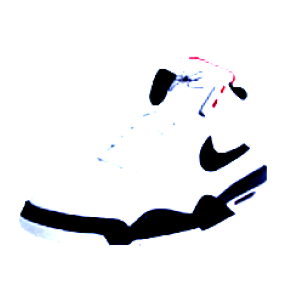

In [ ]:
TensorImage(img).show()
#vect
newvect[ii].data.cpu().numpy(),vect

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([0.58476096, 0.51840806, 0.6129237 , ..., 0.5485854 , 0.5227863 , 0.53140783], dtype=float32)

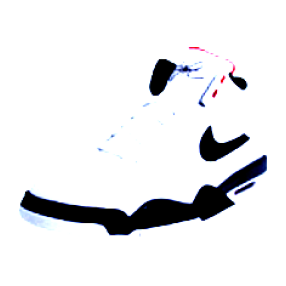

In [ ]:
keepps_ = [dls1[0].vocab[c] for c in query_y]
ii_ = keepps_.index(query_image)
img_ = query_img[ii_,:,:,:]
cls = keepcls[ii_]
TensorImage(img_).show()
(mnetv2(query_img))[ii_].data.cpu().numpy()

In [ ]:
img-img_

In [ ]:
saved_feats = df.loc[query_ind,['features']].features.values[0]

saved_feats.shape, saved_feats.max()

((1280,), 2.4456983)

In [ ]:
df[["path","classes"]].head(25)

,path,classes
0,Boots/Ankle/A. Testoni/7965307.5291.jpg,0
1,Boots/Ankle/A. Testoni/7999255.363731.jpg,1
2,Boots/Ankle/A. Testoni/8000978.364150.jpg,2
3,Boots/Ankle/AIGLE/8113228.1897.jpg,3
4,Boots/Ankle/AIGLE/8113228.1912.jpg,4
5,Boots/Ankle/AIGLE/8113228.3.jpg,5
6,Boots/Ankle/ALDO/8045630.60941.jpg,6
7,Boots/Ankle/ALDO/8045637.3.jpg,7
8,Boots/Ankle/ALDO/8045654.3.jpg,8
9,Boots/Ankle/ALDO/8045660.3.jpg,9


In [ ]:
query_ind[0]

27079

In [ ]:
type(dls.train_ds.vocab)

fastai.data.transforms.CategoryMap

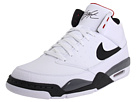

In [ ]:
base_im = Image.open(path_images/query_image)
base_im

In [ ]:
df.loc[query_ind[0],"features"]

array([0.91868997, 0.41414455, 0.54017013, ..., 0.52980435, 0.68767554, 0.01807434], dtype=float32)

In [ ]:
# check that we can get the same image from the dataloader

fnames = L(dls[0].vocab)
class_i = fnames.index(query_image)




In [ ]:
fnames2 = L(dls.train_ds.vocab)

dls.train_ds.items['path']

#fnames[:10],fnames2[:10]

0                    Boots/Ankle/A. Testoni/7965307.5291.jpg
1                  Boots/Ankle/A. Testoni/7999255.363731.jpg
2                  Boots/Ankle/A. Testoni/8000978.364150.jpg
3                         Boots/Ankle/AIGLE/8113228.1897.jpg
4                         Boots/Ankle/AIGLE/8113228.1912.jpg
                                ...                         
33224     Slippers/Slipper Heels/Daniel Green/105772.570.jpg
33225      Slippers/Slipper Heels/Daniel Green/105772.72.jpg
33226    Slippers/Slipper Heels/Daniel Green/117456.7907.jpg
33227      Slippers/Slipper Heels/L.B. Evans/7590239.255.jpg
33228       Slippers/Slipper Heels/L.B. Evans/7590239.72.jpg
Name: path, Length: 33229, dtype: object

In [ ]:
class_ind = df[df["classes"]==class_i].index
class_ind[0]


27079

In [ ]:
im,c = dls.train_ds[class_ind[0]]
c_idx = dls.train_ds.vocab.o2i[query_image]

c_idx

27079

In [ ]:

im.shape

(102, 136)

In [ ]:
sized_im,c = dls.train.do_item(class_ind[0])
type(sized_im),sized_im.shape, c

(fastai.torch_core.TensorImage, (3, 224, 224), TensorCategory(27079))

<AxesSubplot:>

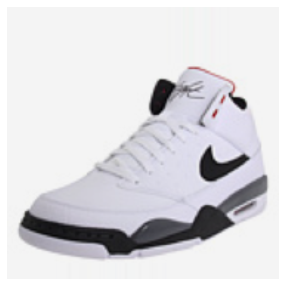

In [ ]:
(sized_im/266).show()

In [ ]:
# grab the dataloader transform
prep_image = dls.train.after_batch

prep_image

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

In [ ]:
# test GPU calculation
# put image on GPU
sized_im = sized_im.to(device)
tensor_im = prep_image(sized_im).to(device)
test_feats = mnetv2(tensor_im).data.cpu().numpy()

type(tensor_im)


fastai.torch_core.TensorImage

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[0.57545424, 0.5231141 , 0.5972381 , ..., 0.55827844, 0.47960386, 0.5746991 ]], dtype=float32)

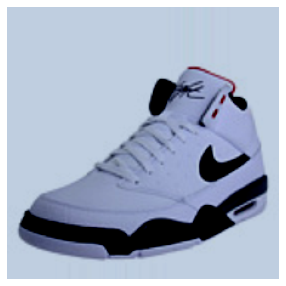

In [ ]:
(tensor_im.squeeze()/3.).show()
test_feats

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([0.6836311 , 0.31259656, 0.19442762, ..., 0.262652  , 0.46943882, 0.02724963], dtype=float32)

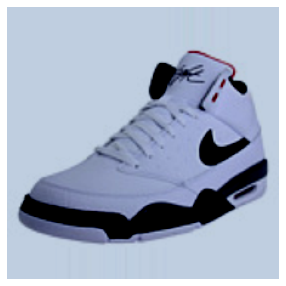

In [ ]:
TensorImage(img/3.).show()
vect

<AxesSubplot:>

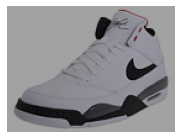

In [ ]:
(TensorImage(base_im)/400.).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[ 0.10817689, -0.21051753, -0.4028105 , ..., -0.29562643, -0.01016504, -0.54744947]], dtype=float32)

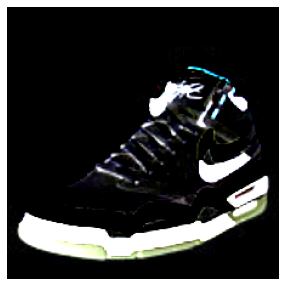

In [ ]:
(TensorImage(img)-tensor_im.squeeze().data.cpu().numpy()).show()
vect-test_feats

In [ ]:
#(TensorImage(img)-tensor_im.squeeze().data.cpu().numpy()).max(),img.max(),tensor_im.max()
(img.min(),img.max()),(tensor_im.min(),tensor_im.max())


((-2.0836544, 2.64),
 (TensorImage(-2.0837, device='cuda:0'), TensorImage(2.6400, device='cuda:0')))

In [ ]:
#whats the difference in values of img and TensorImage(img)

(img[:,100:105,100:105],tensor_im.squeeze().data.cpu().numpy()[:,100:105,100:105])

(array([[[1.6495421, 1.6837916, 1.5981679, 1.5810431, 1.5981679],
         [1.6666669, 1.7009164, 1.6666669, 1.6495421, 1.6324173],
         [1.6495421, 1.6837916, 1.7180412, 1.7009164, 1.6837916],
         [1.6324173, 1.7009164, 1.7180412, 1.7180412, 1.7009164],
         [1.5810431, 1.735166 , 1.7009164, 1.6837916, 1.6666669]],
 
        [[1.7983196, 1.8333336, 1.7457986, 1.7282915, 1.7457986],
         [1.8158265, 1.8508406, 1.8158265, 1.7808126, 1.7633055],
         [1.8158265, 1.8333336, 1.8683475, 1.8508406, 1.8158265],
         [1.7983196, 1.8508406, 1.8683475, 1.8683475, 1.8333336],
         [1.7457986, 1.9033616, 1.8508406, 1.8333336, 1.8158265]],
 
        [[2.1345537, 2.1868412, 2.0996954, 2.082266 , 2.1171246],
         [2.151983 , 2.2042706, 2.1694121, 2.151983 , 2.1694121],
         [2.0996954, 2.151983 , 2.2042706, 2.2216997, 2.2216997],
         [2.0474079, 2.1345537, 2.2042706, 2.2216997, 2.2216997],
         [1.9951203, 2.151983 , 2.151983 , 2.151983 , 2.1345537]]], dt

In [ ]:
test_feats.shape, test_feats.max()

((1, 1280), 0.82997066)

In [ ]:
batch_t = tensor_im.expand(64,-1,-1,-1)
batch_feats = mnetv2(batch_t).data.cpu().numpy()
batch_feats.max(),batch_t.shape,test_feats.max(),saved_feats.max()

(0.82997316, (64, 3, 224, 224), 0.82997066, 2.4865925)

In [ ]:
tensor

continued in "02_model.ipynb"

In [ ]:
# img_tensors = [tensor(Image.open(path_images/o)) for o in df.path]
# len(img_tensors)

# stackeD_img = torch.stack(img_tensors).float()/255
# stackeD_img.shape

In [ ]:
# def _mobilenetv2_split(m:nn.Module): 
#     return (m[0][0][10],m[1])(m:nn.Module): return (m[0][0][10],m[1])

#mobilenet_split = lambda m: (m[0][0][10], m[1])
#arch  = torchvision.models.mobilenet_v2

#identity = Identity()

#arch.classifier = Identity()

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model_conv = model_conv.to(device)

#learn = cnn_learner(dls, models.mobilenet_v2, cut=-1, pretrained=True)

n_out = 1280
mnetv2 = create_cnn_model(arch, 
                 n_out, 
                 pretrained=True,
                 cut=-1,
                 custom_head=identity)


learn_mnetv2 = cnn_learner(dls,arch,n_out, 
                             pretrained=True,cut=-1,
                             custom_head=identity,
                          metrics=lambda x: x)

learn_mnetv2.predict()

In [ ]:
mnetv2(imgs)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
path_images/query_image

Path('/home/ergonyc/Projects/DATABASE/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg')

In [ ]:
batchn = 0

for imgs,classes in dls[0]:
    

    cs = classes.data.cpu().numpy()
    

    ps = [dls[0].vocab[c] for c in cs]
    
    if query_image in ps:
        svout = imgs
        outs = model_conv(imgs).data.cpu().numpy()
        
        print('found it')
        break
    
    batchn += 1


    
batchn

found it


918

In [ ]:
im,cls = dls.train_ds[6879]
im,cls,dls.train.vocab[cls]


#dls.train.before_batch(27079)

(PILImage mode=RGB size=136x102,
 TensorCategory(27079),
 'Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg')

In [ ]:
im_idx = ps.index(query_image)

ValueError: 'Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg' is not in list

In [ ]:
image = svout[im_idx]
print(type(image))
feat_test = model_conv(image.unsqueeze(0))

feat_test

<class 'fastai.torch_core.TensorImage'>


TensorImage([[0.5641, 0.5249, 0.6088,  ..., 0.5313, 0.4860, 0.4929]], device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
outs = model_conv(imgs)

imgs.shape,outs.shape,outs.type,imgs.max()

((13, 3, 224, 224),
 (13, 1280),
 <function TensorImage.type>,
 TensorImage(2.6400, device='cuda:0'))

In [ ]:
query_image = "Shoes/Sneakers and Athletic Shoes/Nike/7716996.288224.jpg"



In [ ]:
sq_im,cls = dls.train.do_item(class_ind[0])

xy=dls.train.after_batch

test_im = xy(sq_im.to(device))
mnetv2(test_im)
batch = test_im.expand(2,-1,-1,-1)
mnetv2(test_im).max(),mnetv2(batch).shape,cls

(tensor(3.2033, device='cuda:0', grad_fn=<MaxBackward1>),
 torch.Size([2, 1000]),
 TensorCategory(27079))

In [ ]:
a,b = dls.train.do_item(27079)
a.shape,b

((3, 224, 224), TensorCategory(27808))

In [ ]:
dls.train.items

,CID,Category,path,Category.Shoes,Category.Boots,Category.Sandals,Category.Slippers,SubCategory.Sneakers.and.Athletic.Shoes,Gender.Men,Gender.Women,Gender.Boys,Gender.Girls,path_and_file,Category1,Category2,Brand,Filename,Sneakers,Boots,Shoes,Slippers,Gender,Adult,Mens,Womens,train,test,validate,t_t_v
0,100627-72,Shoes,Shoes/Oxfords/Bostonian/100627.72.jpg,1,0,0,0,0,1,0,0,0,"[Shoes, Oxfords, Bostonian, 100627.72.jpg]",Shoes,Oxfords,Bostonian,100627.72.jpg,False,False,True,False,Men,True,True,False,True,False,False,train
1,100627-255,Shoes,Shoes/Oxfords/Bostonian/100627.255.jpg,1,0,0,0,0,1,0,0,0,"[Shoes, Oxfords, Bostonian, 100627.255.jpg]",Shoes,Oxfords,Bostonian,100627.255.jpg,False,False,True,False,Men,True,True,False,True,False,False,train
2,100657-72,Shoes,Shoes/Oxfords/Bostonian/100657.72.jpg,1,0,0,0,0,1,0,0,0,"[Shoes, Oxfords, Bostonian, 100657.72.jpg]",Shoes,Oxfords,Bostonian,100657.72.jpg,False,False,True,False,Men,True,True,False,True,False,False,train
3,100657-216,Shoes,Shoes/Oxfords/Bostonian/100657.216.jpg,1,0,0,0,0,1,0,0,0,"[Shoes, Oxfords, Bostonian, 100657.216.jpg]",Shoes,Oxfords,Bostonian,100657.216.jpg,False,False,True,False,Men,True,True,False,True,False,False,train
4,101026-3,Boots,Boots/Mid-Calf/Durango/101026.3.jpg,0,1,0,0,0,1,0,0,0,"[Boots, Mid-Calf, Durango, 101026.3.jpg]",Boots,Mid-Calf,Durango,101026.3.jpg,False,True,False,False,Men,True,True,False,True,False,False,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50020,8168300-128,Shoes,Shoes/Heels/J. Renee/8168300.128.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.128.jpg]",Shoes,Heels,J. Renee,8168300.128.jpg,False,False,True,False,Women,True,False,True,True,False,False,train
50021,8168300-742,Shoes,Shoes/Heels/J. Renee/8168300.742.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.742.jpg]",Shoes,Heels,J. Renee,8168300.742.jpg,False,False,True,False,Women,True,False,True,True,False,False,train
50022,8168300-57113,Shoes,Shoes/Heels/J. Renee/8168300.57113.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.57113.jpg]",Shoes,Heels,J. Renee,8168300.57113.jpg,False,False,True,False,Women,True,False,True,True,False,False,train
50023,8168300-384413,Shoes,Shoes/Heels/J. Renee/8168300.384413.jpg,1,0,0,0,0,0,1,0,0,"[Shoes, Heels, J. Renee, 8168300.384413.jpg]",Shoes,Heels,J. Renee,8168300.384413.jpg,False,False,True,False,Women,True,False,True,True,False,False,train


In [ ]:
idx1 = dls.train.get_idxs()
a,b = dls.train.do_item(0)
a.shape,b,idx1[:10]

((3, 224, 224), TensorCategory(21259), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
dls.train.shuffle = False
idx2 = dls.train.get_idxs()
a,b = dls.train.do_item(4)
print(a.shape,b,idx2[:10])
a

(3, 224, 224) TensorCategory(5823) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


TensorImage([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)

In [ ]:
fnames.o2i[query_image]

27079

In [ ]:
fnames.index(query_image)

NameError: name 'fnames' is not defined

In [ ]:
# use a Fastai learner to calculate the features...  We simply set it up, but don't actually need to "fit it"

# i need just the arcitecture... 
model_conv = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# just read this off: model_conv.classifier
num_categories = 4
num_ftrs = model_conv.classifier._modules['1'].in_features
model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)

def trns_mobilenet_v2():
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)
    
    return model_conv

mobilenet_split = None #lambda m: (m[0][0][10], m[1])
cut = None


mnet2 = torchvision.models.mobilenet_v2(pretrained=True)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
mnet2.classifier = Identity()


learn = cnn_learner(dls, model_conv, splitter=mobilenet_split,cut=-1, pretrained=True)




learn = cnn_learner(dls, model_conv, metrics=error_rate, pretrained=true)
learn.save('pretrained_only')


In [ ]:
# now we have all our features...  lets just look for neighborrs


# annoy knn?   pre-compute the neighbors for each element

# ImageDataLoader instead of block API 

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

In [ ]:
dls = ImageDataLoaders.from_df(df, path=path_images,fn_col='path',label_col='Category',valid_pct=0.0)

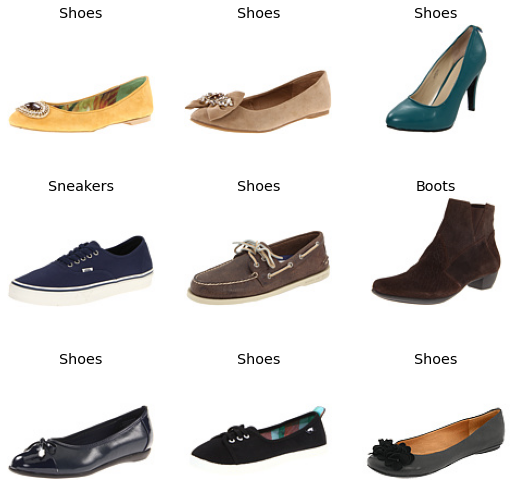

In [ ]:
dls[0].show_batch()

In [ ]:
    
tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

item_tfms = [Resize(160,method='pad', pad_mode='border')]
batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

# put everythign in train, and don't do any augmentation since we are just going 
def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
#def get_feat(r): return r["Unnamed: 0"]
def get_feat(r): return r['path']
#def get_feat(r): return r['CID']


# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)  # border pads white...

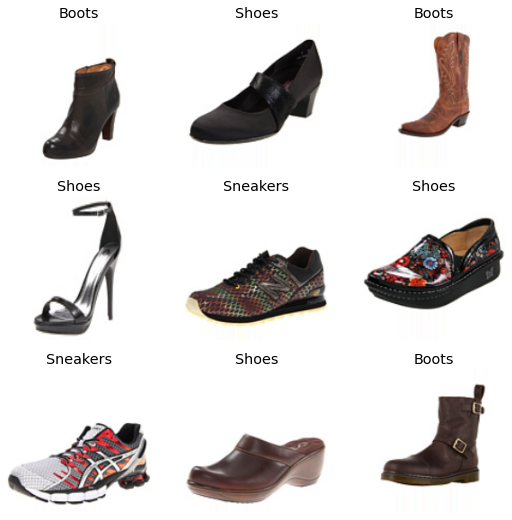

In [ ]:
dls = dblock.dataloaders(df,bs=256,drop_last=False)


dls.show_batch()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# strip off the "classifier" and use the "RAW" embedding

# fastai 

In [ ]:
# make a linear classifier (aka logistic regression)

In [ ]:
#df = pd.read_csv(f"{filename}.csv")
    
    
tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

In [ ]:
# put everythign in train, and don't do any augmentation since we are just going 
def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
#def get_feat(r): return r["Unnamed: 0"]
#def get_feat(r): return r['path']
#def get_feat(r): return r['CID']

df.shape
split_list = df.index.to_list()


# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(160,method='pad', pad_mode='border')
                  )
#                   batch_tfms=tfms)  # border pads white...





In [ ]:
# transfer learning

In [ ]:
model_conv = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# just read this off: model_conv.classifier
num_categories = 4
num_ftrs = model_conv.classifier._modules['1'].in_features
model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)

def trns_mobilenet_v2():
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)
    
    return model_conv

mobilenet_split = lambda m: (m[0][0][10], m[1])

learn = cnn_learner(dls, models.mobilenet_v2, splitter=mobilenet_split,cut=-1, pretrained=True)

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep


RuntimeError: CUDA out of memory. Tried to allocate 226.00 MiB (GPU 0; 7.79 GiB total capacity; 2.62 GiB already allocated; 193.50 MiB free; 2.67 GiB reserved in total by PyTorch)

In [ ]:
inputs.size()

outs = model_conv(inputs)

In [ ]:
len(dls[0].vocab)

33229

In [ ]:
idx1[:10]

[22202, 12998, 10291, 15574, 3018, 26007, 3319, 18637, 14375, 12439]

In [ ]:
clss[:10],indices[:10]

([25419, 4873, 33072, 10663, 20373, 10537, 29894, 5560, 24690, 12632],
 [15840, 12542, 32339, 7527, 1998, 19336, 4696, 22829, 16601, 20054])

In [ ]:
len(indices),len(vects),outs.shape

(33229, 33229, (13, 1000))

In [ ]:
df.tail(5)['Unnamed: 0']

33224    50020
33225    50021
33226    50022
33227    50023
33228    50024
Name: Unnamed: 0, dtype: int64

In [ ]:
list(classes.data.cpu().numpy())

[16101,
 6563,
 24573,
 1867,
 31390,
 18538,
 7569,
 32715,
 12957,
 23181,
 14892,
 30953,
 12812,
 1046,
 5643,
 31443,
 11592,
 24377,
 11910,
 2571,
 13508,
 15065,
 23270,
 24801,
 26010,
 14636,
 7566,
 18989,
 130,
 18471,
 7233,
 23313,
 12357,
 26678,
 10754,
 9932,
 31672,
 18692,
 9304,
 18875,
 30830,
 27903,
 13319,
 21856,
 30530,
 4280,
 29354,
 18852,
 9693,
 4901,
 20869,
 26468,
 555,
 28503,
 29188,
 6193,
 16858,
 24569,
 5940,
 22649,
 12574,
 10027,
 9640,
 24080]

In [ ]:
doc(RandomSplitter)

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep

RuntimeError: CUDA out of memory. Tried to allocate 332.00 MiB (GPU 0; 3.95 GiB total capacity; 3.26 GiB already allocated; 84.19 MiB free; 3.31 GiB reserved in total by PyTorch)

In [ ]:
doc(dblock.dataloaders)

In [ ]:
import torchvision
# def def _mobilenetv2_split(m:nn.Module): 
#     return (m[0][0][10],m[1])(m:nn.Module): return (m[0][0][10],m[1])

mobilenet_split = lambda m: (m[0][0][10], m[1])
arch  = torchvision.models.mobilenet_v2
#arch  = torchvision.models.mobilenet_v2(pretrained=True)

learn = cnn_learner(dls, arch, cut=-1, splitter=mobilenet_split,metrics=error_rate, pretrained=True)

In [ ]:
dls.valid.get_idxs()

[]

In [ ]:
learn.predict(dls.dataset[10][0])

('Sneakers', tensor(3), tensor([0.0145, 0.0430, 0.1703, 0.7722]))

In [ ]:
dls.dataset[10][1]

TensorCategory(0)

In [ ]:
dls.show_batch(nrows=1, ncols=5)

RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 3.95 GiB total capacity; 3.28 GiB already allocated; 28.19 MiB free; 3.31 GiB reserved in total by PyTorch)

In [ ]:
#img_tensors = [(model_conv(tensor(im)) ,tc) for im,tc in dblock.datasets(df)

coll = range(16)
dl = DataLoader(coll, batch_size=5, shuffle=False)
list(dl)



RuntimeError: Could not infer dtype of PILImage

In [ ]:
dblock.datasets(df)

(#33229) [(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(1)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0)),(PILImage mode=RGB size=136x102, TensorCategory(0))...]

In [ ]:
len(dls.train_ds)

33229

Setting-up type transforms pipelines
0               0       100627-72     Shoes   
1               1      100627-255     Shoes   
2               2       100657-72     Shoes   
3               3      100657-216     Shoes   
4               4        101026-3     Boots   
...           ...             ...       ...   
33224       50020     8168300-128     Shoes   
33225       50021     8168300-742     Shoes   
33226       50022   8168300-57113     Shoes   
33227       50023  8168300-384413     Shoes   
33228       50024    8169712-2557  Sneakers   

                                                                   path  \
0                                 Shoes/Oxfords/Bostonian/100627.72.jpg   
1                                Shoes/Oxfords/Bostonian/100627.255.jpg   
2                                 Shoes/Oxfords/Bostonian/100657.72.jpg   
3                                Shoes/Oxfords/Bostonian/100657.216.jpg   
4                                   Boots/Mid-Calf/Durango/101026.3.jp


Final sample: (PILImage mode=RGB size=136x102, TensorCategory(1))


0               0       100627-72     Shoes   
1               1      100627-255     Shoes   
2               2       100657-72     Shoes   
3               3      100657-216     Shoes   
4               4        101026-3     Boots   
...           ...             ...       ...   
33224       50020     8168300-128     Shoes   
33225       50021     8168300-742     Shoes   
33226       50022   8168300-57113     Shoes   
33227       50023  8168300-384413     Shoes   
33228       50024    8169712-2557  Sneakers   

                                                                   path  \
0                                 Shoes/Oxfords/Bostonian/100627.72.jpg   
1                                Shoes/Oxfords/Bostonian/100627.255.jpg   
2                                 Shoes/Oxfords/Bostonian/100657.72.jpg   
3                                Shoes/Oxfords/Bostonian/100657.216.jpg   
4                                   Bo


No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}
    starting from
      (TensorImage of size 8x3x168x168, TensorCategory([1, 1, 3, 0, 0, 0, 1, 0], device='cuda:0'))
    applying IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} gives
      (TensorImage of size 8x3x168x168, TensorCategory([1, 1, 3, 0, 0, 0, 1, 0], device='cuda:0'))


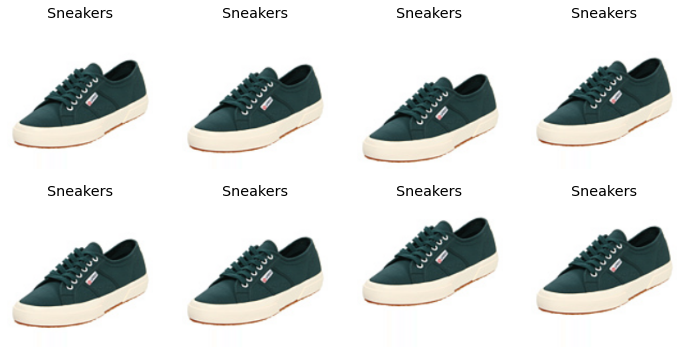

In [ ]:
dblock.summary(df, bs=8, show_batch=True, unique=True)

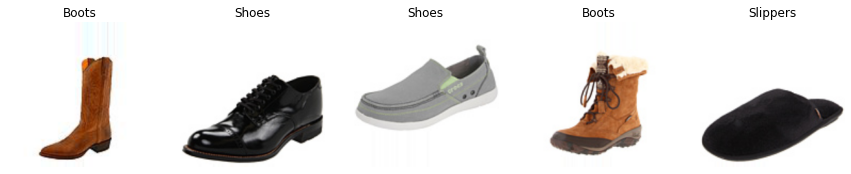

In [ ]:
dls1.show_batch(nrows=1, ncols=5) 


In [ ]:
dls1.train.get_idxs = lambda: Inf.ones


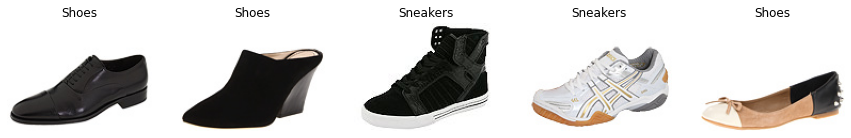

In [ ]:
dls.show_batch(nrows=1, ncols=5)

In [ ]:
x,y = dls.train.one_batch()
x.shape

RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 3.95 GiB total capacity; 3.27 GiB already allocated; 28.19 MiB free; 3.31 GiB reserved in total by PyTorch)

In [ ]:
xx = model_conv(x)

RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 3.95 GiB total capacity; 3.26 GiB already allocated; 48.19 MiB free; 3.29 GiB reserved in total by PyTorch)

In [ ]:
doc(setup_aug_tfms)

## CLEAN the database... create fast.ai type widgets

(1.2022644114040304e-06, 7.585775847473997e-07)

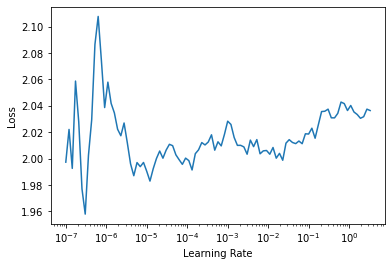

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep


(9.12010818865383e-08, 6.309573450380412e-07)

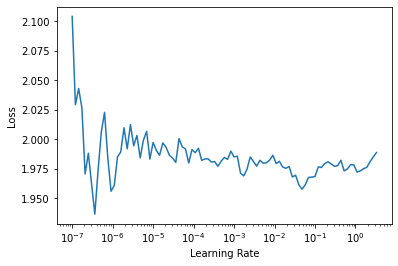

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep


In [ ]:
# choose learning rate around 1e-6
#lr = 10e-6
learn.fine_tune(2)

In [ ]:
doc(learn.freeze)

### learn.fine_tune(2, base_lr=3e-3)

lr_min,lr_steep = learn.lr_find()
learn.fine_tune(2, base_lr=3e-3)

In [ ]:
learn.fit_one_cycle(3, 3e-6)



learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

KeyboardInterrupt: 

IndexError: list index out of range

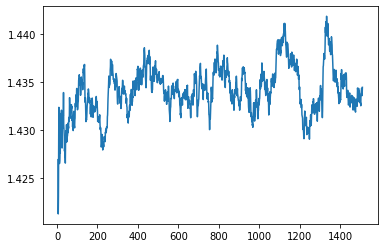

In [ ]:
learn.recorder.plot_loss()


# need to make a function to load data... 

In [ ]:
# from tensorflow import kerasratio=(0.75, 1.3333333333333333)
# from tensorflow.python.keras import backend as K

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import load_img,img_to_array
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten,Input
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications import imagenet_utils
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# import tensorflow as tf

In [ ]:

today = datetime.today()
today

datetime.datetime(2020, 12, 14, 22, 11, 44, 540704)

In [ ]:
# misnomer... don't actually have features yet...
# save the simple file
summary_file = f'./categories_with_features_{today:%b-%d-%Y}.pkl'
df.to_pickle(summary_file)

summary_file = f'./categories_with_features_{today:%b-%d-%Y}.json'
df.to_json(summary_file)



In [ ]:
# save the simple file
summary_file ='train_test_val_Jun-25-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Jun-25-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Jun-25-2020.json')

        

In [ ]:
df.path_and_file


0               [Shoes, Oxfords, Bostonian, 100627.72.jpg]
1              [Shoes, Oxfords, Bostonian, 100627.255.jpg]
2               [Shoes, Oxfords, Bostonian, 100657.72.jpg]
3              [Shoes, Oxfords, Bostonian, 100657.216.jpg]
4                 [Boots, Mid-Calf, Durango, 101026.3.jpg]
                               ...                        
50020            [Shoes, Heels, J. Renee, 8168300.128.jpg]
50021            [Shoes, Heels, J. Renee, 8168300.742.jpg]
50022          [Shoes, Heels, J. Renee, 8168300.57113.jpg]
50023         [Shoes, Heels, J. Renee, 8168300.384413.jpg]
50024    [Shoes, Sneakers and Athletic Shoes, Travis Ma...
Name: path_and_file, Length: 34278, dtype: object

In [ ]:
      
# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Feb-06-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Feb-05-2020.json')

        

# this fits the models

# PYTORCH tutorial on transfer learning.. purt torch

In [ ]:
plt.ion()   # interactive mode

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.
#
# The problem we're going to solve today is to train a model to classify
# **ants** and **bees**. We have about 120 training images each for ants and bees.
# There are 75 validation images for each class. Usually, this is a very
# small dataset to generalize upon, if trained from scratch. Since we
# are using transfer learning, we should be able to generalize reasonably
# well.
#
# This dataset is a very small subset of imagenet.
#
# .. Note ::
#    Download the data from
#    `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
#    and extract it to the current directory.

# Data augmentation and normalization for training
# Just normalization for validation
IMG_SIZE = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
    ]),
}

#data_dir = 'hymenoptera_data'
data_dir = "mona_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [ ]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# It should take around 15-25 min on CPU. On GPU though, it takes less than a
# minute.
#

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

######################################################################
#

visualize_model(model_ft)

In [ ]:
######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

model_conv = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 7)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_conv)

plt.ioff()
plt.show()

# Transfer learning with a pretrained ConvNet
Lets try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. Simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
We will not (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

General machine learning workflow:

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from os.path import isfile

In [ ]:
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.models import Model
#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import os




def no_transfer_model(num_classes,input_shape):
    '''Implementation of vgg11 architecture '''

    X_in = Input(input_shape)
    X = Conv2D(64,3,activation='relu',padding='same')(X_in)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(128,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Flatten()(X)
    X = Dense(4096,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(4096,activation='relu')(X)
    X_out = Dense(num_classes,activation='softmax')(X)
    model = Model(input = X_in, output = X_out)

    return model



def model(model_name, num_classes, is_transfer, num_freeze_layer, weights_path,input_shape):

#     # vgg16_model
#     conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#     #conv_base_16.summary()


    #graph = tf.compat.v1.get_default_graph()

    if not is_transfer or model_name == 'simple':
        model = no_transfer_model(num_classes,input_shape)
        print('how did i get here')
        return model        
    
    
#     if model_name == 'vgg_16':
#         conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_16
#     elif model_name == 'vgg_19':
#         conv_base_19 = VGG19(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_19
#     elif model_name == 'mnNet_v2':
#         mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
#         model = mobileNet_v2
    if model_name == 'mnNet_v2':
        mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
        model = mobileNet_v2
    # final_model
    #global graph 
    #graph = tf.get_default_graph()
  
    print(model_name) 
    print(weights_path)
    print('------x-x-x-x-x-x---x-xx-x-x-x-xx------')   
    print(input_shape) 

    # freeze the given number of layers
    for layer in model.layers[:num_freeze_layer]:
        layer.trainable = False

    # Adding custom layers # maybe have a problem with the mobileNet_v2 output?
    m_out = model.output

    m_flatten = Flatten()(m_out)
    m_dense = Dense(1024,activation='relu')(m_flatten)
    m_drop = Dropout(0.5)(m_dense)
    m_dense = Dense(1024,activation='relu')(m_drop)
    pred_out = Dense(num_classes,activation='softmax')(m_dense)

    # final_model
    #with graph.as_default():
    #    final_model = Model(input=model.input,output=pred_out)
    final_model = Model(input=model.input,output=pred_out)

    print(final_model.summary())
    return final_model

# these functions set up the data

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array
from os.path import isdir,abspath,join
from os import listdir

data_path = './data/' # path of the data
train_path = './train'
test_path = './test'

def load_img_arr(p):
    return img_to_array(load_img(p))


def train_val_generator(
    batch_size, train_path,test_path,target_size=(136,136)):

    gen_tr = _train_generator()
    gen_val = _val_generator()

    sample = apply_to_images_in_subdirs(train_path,load_img_arr,num_per_cls = batch_size)
    sample = np.array(sample)
    gen_tr.fit(sample)
    gen_val.fit(sample)

    gen_tr = init_directory_generator(
        gen_tr,train_path,batch_size,target_size=target_size)

    gen_val = init_directory_generator(
        gen_val,test_path,batch_size,target_size=target_size)

    return gen_tr,gen_val


def _train_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=180,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )


def _val_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )

def apply_to_images_in_subdirs(parent_dir, func, num_per_cls=None, **kwargs):
    results = []
    for cls_dir_name in listdir(parent_dir):
        cls_dir = abspath(join(parent_dir, cls_dir_name))
        r = _apply_to_first_n_in_dir(func, cls_dir, num_per_cls, **kwargs)
        results += r
    return results


def _apply_to_first_n_in_dir(func, dir_, num_per_cls, **kwargs):
    if not isdir(dir_):
        return []
    results = []
    for path in listdir(dir_)[:num_per_cls]:
        abspath_ = abspath(join(dir_, path))
        result = func(abspath_, **kwargs)
        results.append(result)
    return results




def init_directory_generator(
    gen, dir_,batch_size, target_size=(136,136),
    class_mode='categorical',shuffle=True):

    return gen.flow_from_directory(
        dir_,
        class_mode = class_mode,
        batch_size = batch_size,
        target_size = target_size,
        shuffle = shuffle
    )

ModuleNotFoundError: No module named 'keras'

# this fits the models

In [ ]:
model_name ='mnNet_v2' #'vgg_16','vgg_19','mnNet_v2','resnet_152','simple'])
is_transfer=True
num_freeze_layer=5
num_classes=4
weights_path='mnNet_v2_weights_tf.h5'
input_shape=(224,224,3)#(img_width,img_height,img_channel)')
batch_size=32
train_path='./train'
test_path='./test'


# model for traning
tr_model = model(model_name,num_classes,is_transfer, num_freeze_layer,weights_path,input_shape)

# train and test generator
train_gen, val_gen = train_val_generator(batch_size,train_path,test_path)

mnNet_v2
mnNet_v2_weights_tf.h5
------x-x-x-x-x-x---x-xx-x-x-x-xx------
(224, 224, 3)


TypeError: ('Keyword argument not understood:', 'input')